## Market Basket Analysis

This notebook conducts a Market Basket Analysis on a dataset of transactions at a bakery, to uncover potential relationships from item-to-item purchases.

The primary goal is to identify and understand <b>frequently co-purchased items</b> using association rules, enabling data-driven recommendations for product bundling, cross-selling, and store layout optimization.

Key objectives of the analysis include:
<ul>
    <li>Preparing and cleaning transaction data for the analysis</li>
    <li>Applying the <b>Apriori algorithm</b> to discover frequent itemsets</li>
    <li>Generating <b>association rules</b> with meaningful metrics, such as support, confidence, and lift</li>
    <li>Visualizing high-value rules to highlight strong item affinities</li>
</ul>

The notebook also performs exploratory analysis of temporal trends, such as purchase activity by day of week, and hour of day. 
These insights help contextualize consumer behaviour and support time-based marketing or staffing decisions.

### Import libraries

In [1]:
import random
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

pd.set_option('display.max_columns', None)

### 📂 Load and Inspect Data

In [2]:
df = pd.read_csv('dataset/Bakery.csv')

In [3]:
df.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend


In [4]:
df.shape

(20507, 5)

In [5]:
df.describe(include='all')

,TransactionNo,Items,DateTime,Daypart,DayType
count,20507.000000,20507,20507,20507,20507
unique,NaN,94,9465,4,2
top,NaN,Coffee,2017-02-17 14:18:20,Afternoon,Weekday
freq,NaN,5471,11,11569,12807
mean,4976.202370,NaN,NaN,NaN,NaN
std,2796.203001,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN
25%,2552.000000,NaN,NaN,NaN,NaN
50%,5137.000000,NaN,NaN,NaN,NaN
75%,7357.000000,NaN,NaN,NaN,NaN


### 🕓 Data Preprocessing

<i> Here, I confirm that there are duplicate rows, but decided to keep duplicate instances of items occurring in the same transaction.
This is under the assumption that customers bought multiple of the same item.</i>

In [6]:
# Check for duplicates
df[df.duplicated()]

,TransactionNo,Items,DateTime,Daypart,DayType
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
25,11,Bread,2016-10-30 10:27:21,Morning,Weekend
49,21,Coffee,2016-10-30 10:49:29,Morning,Weekend
101,49,Coffee,2016-10-30 12:23:01,Afternoon,Weekend
123,60,Coffee,2016-10-30 13:14:04,Afternoon,Weekend
...,...,...,...,...,...
20390,9618,Cake,2017-08-04 15:04:45,Afternoon,Weekend
20404,9627,Coffee,2017-08-04 16:05:07,Afternoon,Weekend
20423,9634,Coffee,2017-08-04 16:30:32,Afternoon,Weekend
20465,9664,Coffee,2017-09-04 11:40:10,Morning,Weekend


In [7]:
# Check for null values
df.isna().sum()

TransactionNo    0
Items            0
DateTime         0
Daypart          0
DayType          0
dtype: int64

In [8]:
# Normalize item names
df['Items'] = df['Items'].str.strip().str.lower()

In [9]:
# Convert datetime to pandas datetime dtype
df['DateTime'] = pd.to_datetime(df['DateTime'])

### 📊 Explore Purchase Patterns & Visualize Trends

In [10]:
df['DayOfWeek'] = df['DateTime'].dt.day_name()
df['Hour'] = df['DateTime'].dt.hour

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=days_order, ordered=True)

daypart_order = ['Morning', 'Afternoon', 'Evening', 'Night']
df['Daypart'] = pd.Categorical(df['Daypart'], categories=daypart_order, ordered=True)

C:\Users\I037082\AppData\Local\Temp\ipykernel_19644\2804540432.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index='Daypart', columns='DayType', aggfunc='size', fill_value=0)
c:\Users\I037082\AppData\Local\anaconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\I037082\AppData\Local\anaconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\I037082\AppData\Local\anaconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend

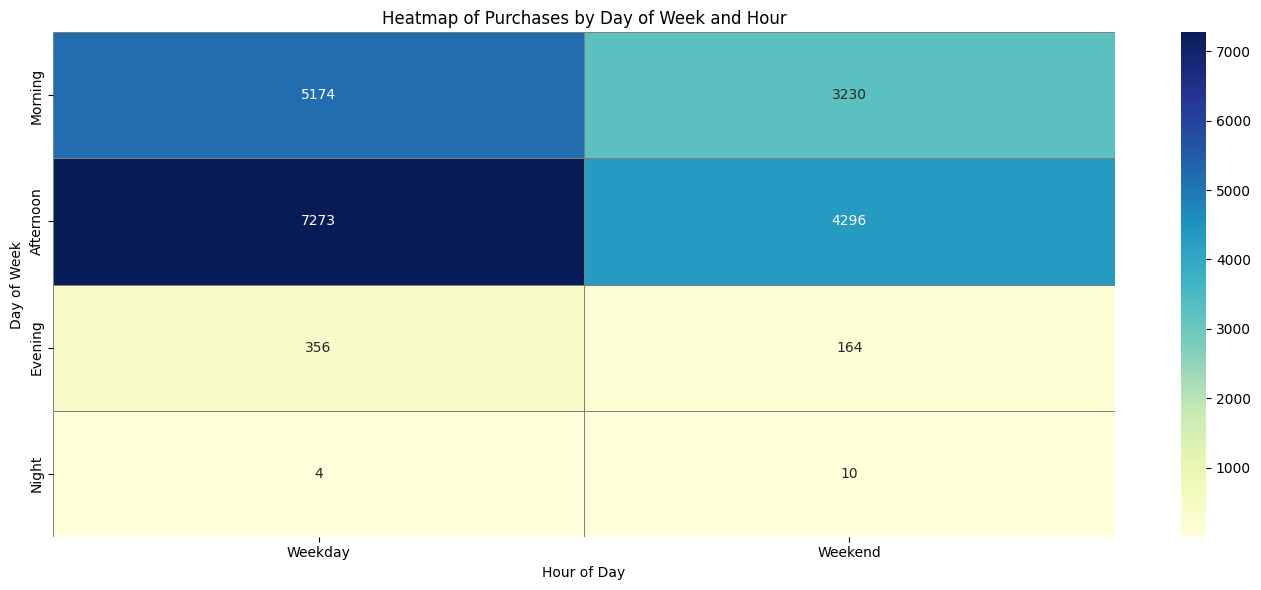

In [ ]:
## Chart: Heatmap of purchases by part of day and by type of day

heatmap_data = df.pivot_table(index='Daypart', columns='DayType', aggfunc='size', fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='gray', annot=True, fmt='d')
plt.title('Heatmap of Purchases by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

C:\Users\I037082\AppData\Local\Temp\ipykernel_2888\4188021362.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index='DayOfWeek', columns='Hour', aggfunc='size', fill_value=0)


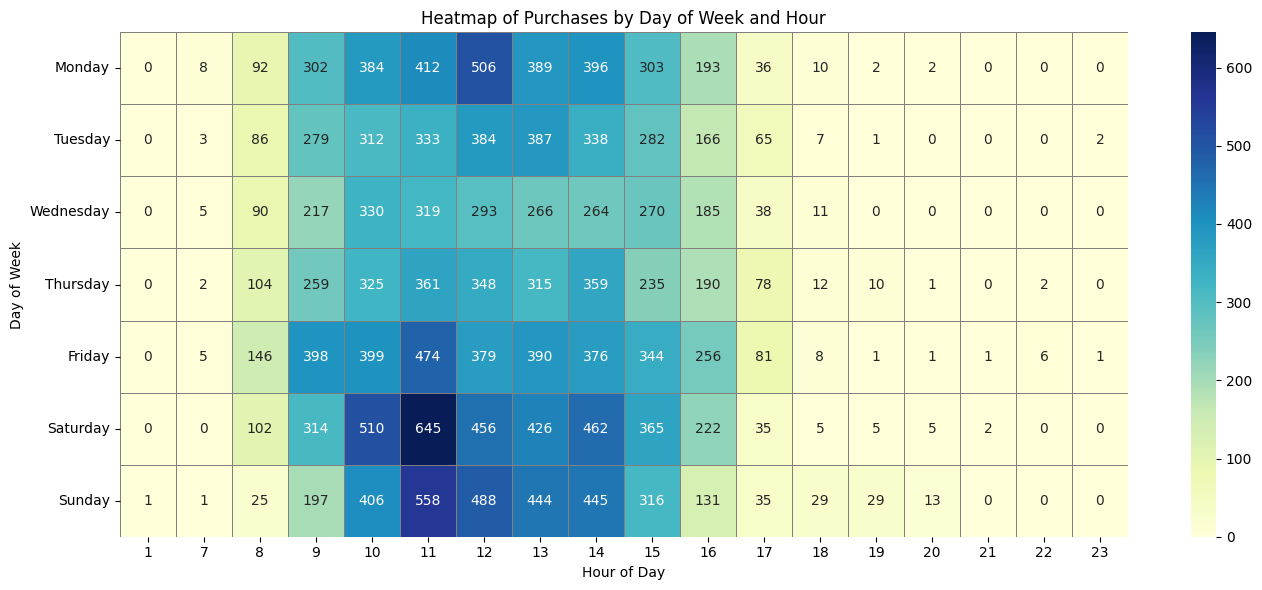

In [ ]:
## Chart: Heatmap of purchases by day of week and by hour

heatmap_data = df.pivot_table(index='DayOfWeek', columns='Hour', aggfunc='size', fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='gray', annot=True, fmt='d')
plt.title('Heatmap of Purchases by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [14]:
# Chart: Total Purchases by Day of Week and Item
grouped = df.groupby(['DayOfWeek', 'Items']).size().reset_index(name='count')
unique_items = grouped['Items'].sort_values().unique()

fig = go.Figure()
for item in unique_items:
    item_data = grouped[grouped['Items'] == item]
    fig.add_trace(go.Scatter(
        x=item_data['DayOfWeek'],
        y=item_data['count'],
        mode='lines+markers',
        name=item,
        visible=False
    ))

fig.data[0].visible = True
buttons = [
    dict(label=item,
         method="update",
         args=[{"visible": [i == j for j in range(len(unique_items))]},
               {"title": f"Purchases by Day of Week: {item}"}])
    for i, item in enumerate(unique_items)
]

fig.update_layout(
    title=f"Purchases by Day of Week: {unique_items[0]}",
    xaxis_title="Day of Week",
    yaxis_title="Number of Purchases",
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True
    }]
)

fig.show()

C:\Users\I037082\AppData\Local\Temp\ipykernel_2888\1105853887.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['DayOfWeek', 'Items']).size().reset_index(name='count')


In [15]:
# Chart: Total Purchases by hour of day and item
grouped = df.groupby(['Hour', 'Items']).size().reset_index(name='count')
unique_items = grouped['Items'].sort_values().unique()

fig = go.Figure()
for item in unique_items:
    item_data = grouped[grouped['Items'] == item]
    fig.add_trace(go.Scatter(
        x=item_data['Hour'],
        y=item_data['count'],
        mode='lines+markers',
        name=item,
        visible=False
    ))

fig.data[0].visible = True
buttons = [
    dict(label=item,
         method="update",
         args=[{"visible": [i == j for j in range(len(unique_items))]},
               {"title": f"Purchases by Hour of Day: {item}"}])
    for i, item in enumerate(unique_items)
]

fig.update_layout(
    title=f"Purchases by Hour of Day: {unique_items[0]}",
    xaxis_title="Hour of Day",
    yaxis_title="Number of Purchases",
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True
    }]
)

fig.show()

### 🔗 Association Rule Mining with Apriori

In [16]:
basket = df.groupby('TransactionNo')['Items'].apply(list)
te = TransactionEncoder()
te_array = te.fit(basket).transform(basket)

basket_df = pd.DataFrame(te_array.astype(int), columns=te.columns_)

In [17]:
# Apriori
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

### 📈 Insights & Recommendations

In [12]:
# Loop through all combinations of DayType and Daypart
for weekpart in df['DayType'].unique():
    for partofday in df['Daypart'].unique():
        segment_df = df[(df['DayType'] == weekpart) & (df['Daypart'] == partofday)]

        if segment_df.empty:
            continue

        transactions = segment_df.groupby('TransactionNo')['Items'].apply(list).tolist()

        # Encode transactions
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

        # Run Apriori
        frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)    ## find frequent itemsets that occur in at least 5% of all transactions
        rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)  ## find rules that have at least 1.2x lift

        # Filter rules
        rules = rules[
            (rules['confidence'] >= 0.5)
        ]

        # Skip further processing if there are no relevant rules for a particular subset
        if len(rules) == 0:
            continue

        ### Remove redundant/symmetric rules
        rules["antecedents_sorted"] = rules["antecedents"].apply(lambda x: tuple(sorted(x)))
        rules["consequents_sorted"] = rules["consequents"].apply(lambda x: tuple(sorted(x)))
        rules["rule_canonical"] = rules.apply(
            lambda row: tuple(sorted(list(row["antecedents"] | row["consequents"]))), axis=1
        )

        # Keep the best-scoring rule for each pair by highest lift
        rules = rules.sort_values("lift", ascending=False)
        rules = rules.drop_duplicates(subset="rule_canonical", keep="first")

        # Drop helper columns
        rules = rules.drop(columns=["antecedents_sorted", "consequents_sorted", "rule_canonical"])

        # Generate insights
        for _, row in rules.iterrows():
            antecedents = ', '.join(row['antecedents'])
            consequents = ', '.join(row['consequents'])
            lift = round(row['lift'], 2)
            confidence = round(row['confidence'] * 100, 1)
            support = round(row['support'] * 100, 2)

            templates = [
                f"{consequents} is a common follow-up to {antecedents}.",
                f"Shoppers frequently combine {antecedents} and {consequents} — especially during {weekpart.lower()} {partofday.lower()}s.",
                f"There's a strong association between {antecedents} and {consequents} on {weekpart.lower()} {partofday.lower()}s.",
                f"{antecedents.capitalize()} and {consequents} are often bought together — consider a bundle offer.",
                f"{weekpart} {partofday.lower()} shoppers tend to purchase {antecedents} with {consequents}, possibly indicating a routine or theme."
            ]
            insight = random.choice(templates)

            print(insight, '\n')


There's a strong association between medialuna and coffee on weekend mornings. 

Weekend afternoon shoppers tend to purchase sandwich with coffee, possibly indicating a routine or theme. 

Shoppers frequently combine postcard and tshirt — especially during weekend evenings. 

coffee is a common follow-up to cake. 

Shoppers frequently combine juice and mineral water — especially during weekday nights. 



#### Key Patterns at a Glance

- ☕ Coffee is a strong complementary item across multiple time slots.
- 🧁 Bakery and breakfast items pair well in the morning.
- 🛍️ Gift or souvenir items like postcards and t-shirts trend in the evening.


#### 📊 Top 10 Association Rules by Lift
This chart highlights the strongest product associations based on lift — how much more likely items are to be bought together than by chance. 

Higher lift values indicate stronger, non-random relationships.

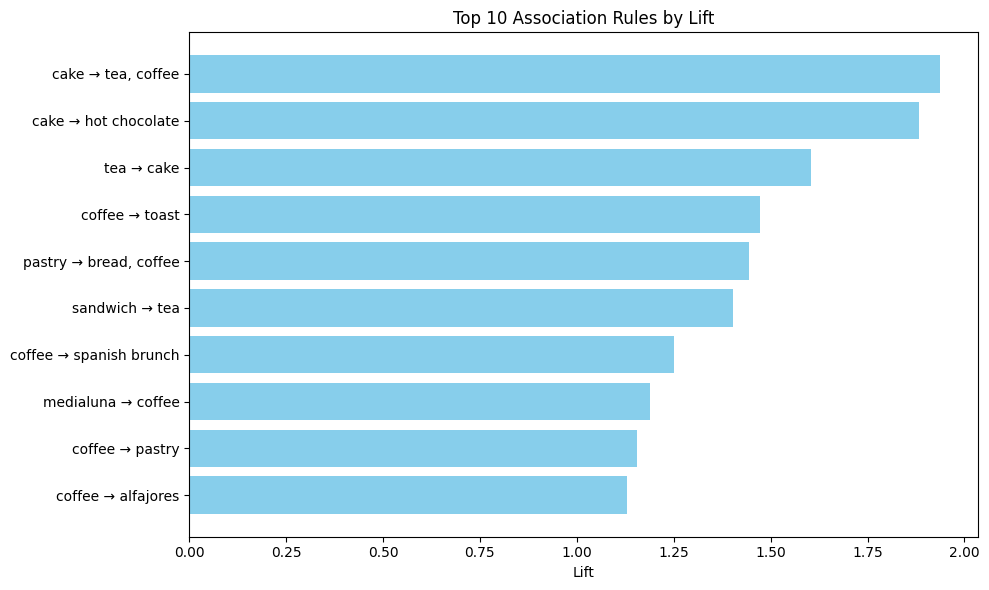

In [19]:
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

### Remove redundant/symmetric rules
# Convert frozensets to sorted tuples for consistent comparison
rules["antecedents_sorted"] = rules["antecedents"].apply(lambda x: tuple(sorted(x)))
rules["consequents_sorted"] = rules["consequents"].apply(lambda x: tuple(sorted(x)))

# Create a canonical rule ID (e.g., {A, B} regardless of direction)
rules["rule_canonical"] = rules.apply(
    lambda row: tuple(sorted(list(row["antecedents"] | row["consequents"]))), axis=1
)

# Keep the best-scoring rule for each canonical pair (e.g., by highest lift)
rules = rules.sort_values("lift", ascending=False)
rules = rules.drop_duplicates(subset="rule_canonical", keep="first")

# Optional: drop helper columns
rules = rules.drop(columns=["antecedents_sorted", "consequents_sorted", "rule_canonical"])

top_rules = rules.sort_values(by='lift', ascending=False).head(10)

# Combine antecedent and consequent for labeling
top_rules['rule'] = top_rules.apply(lambda row: f"{', '.join(row['antecedents'])} → {', '.join(row['consequents'])}", axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_rules['rule'], top_rules['lift'], color='skyblue')
plt.xlabel('Lift')
plt.title('Top 10 Association Rules by Lift')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()

#### 📈 Scatter Plot: Confidence vs Lift
This plot shows the trade-off between confidence and lift across all rules. 

Rules in the upper-right corner are both strong and reliable, representing high-impact opportunities for promotions or bundling.

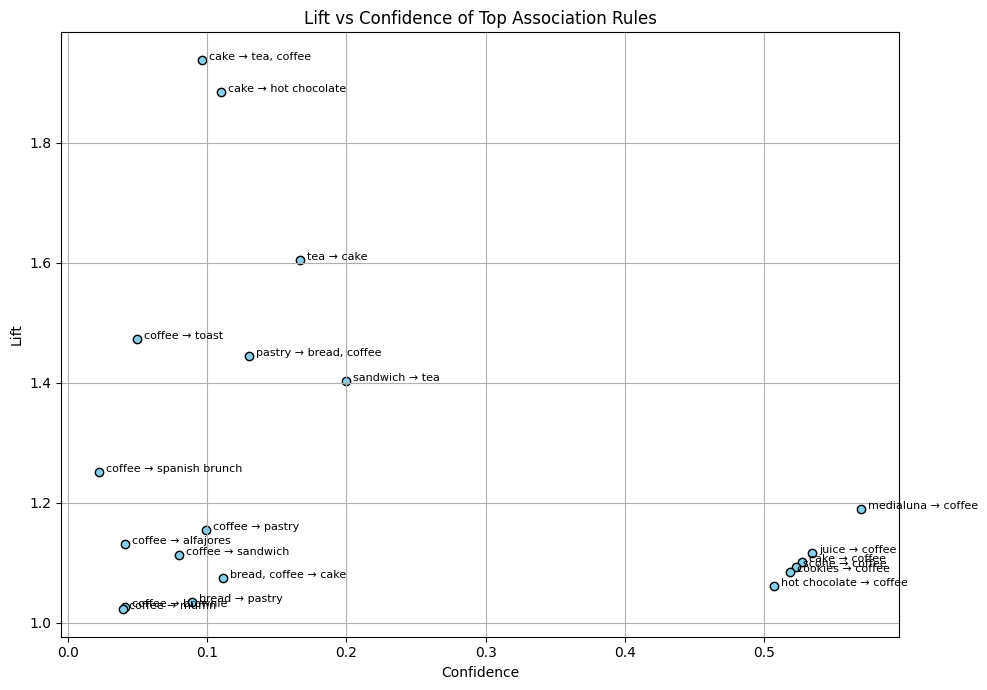

In [20]:
# Optional: select top N rules to avoid clutter
top_rules = rules.sort_values(by='lift', ascending=False).head(20)

# Prepare labels
top_rules['label'] = top_rules.apply(
    lambda row: f"{', '.join(row['antecedents'])} → {', '.join(row['consequents'])}", axis=1
)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(top_rules['confidence'], top_rules['lift'], color='skyblue', edgecolor='black')

# Add labels to each point
for i, row in top_rules.iterrows():
    plt.text(
        row['confidence'] + 0.005,  # small offset to avoid overlap
        row['lift'],
        row['label'],
        fontsize=8
    )

plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Lift vs Confidence of Top Association Rules')
plt.grid(True)
plt.tight_layout()
plt.show()


#### 🕸️ Network Graph of Item Associations
This network diagram visualizes the most influential product associations. 

Arrows represent the direction of buying patterns (e.g., item A often leads to item B), helping to uncover bundling or layout opportunities.

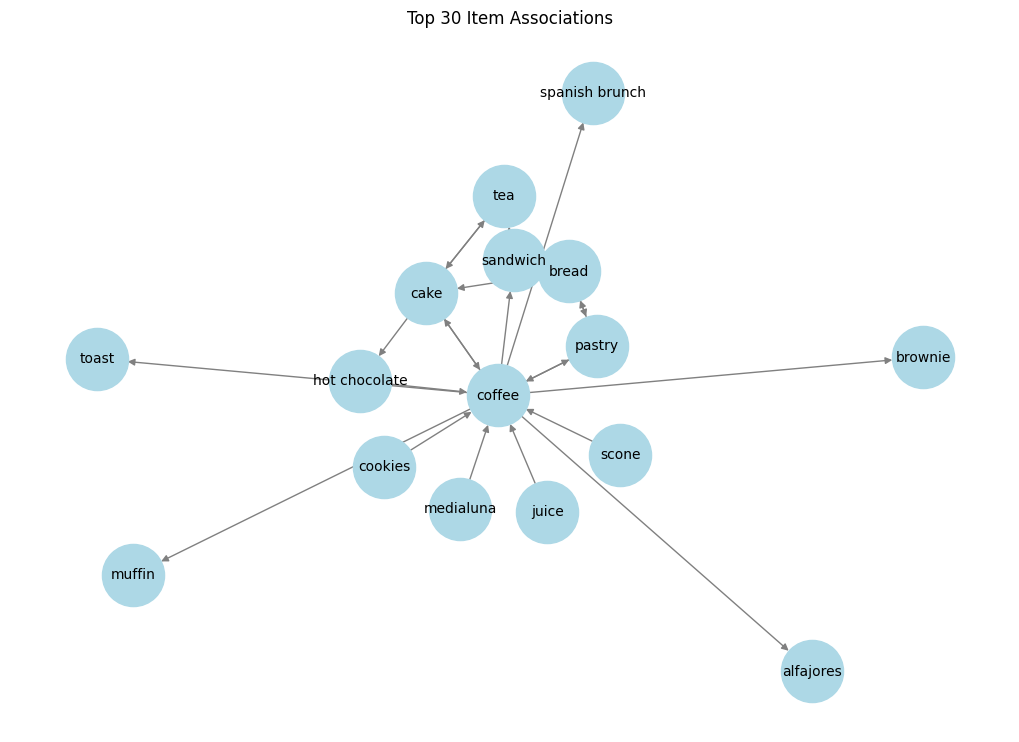

In [21]:
G = nx.DiGraph()

N = 30
top_n = rules.sort_values('lift', ascending=False).head(N)
for _, row in top_n.iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G.add_edge(ant, con, weight=row['lift'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, edge_color='gray')
plt.title(f'Top {N} Item Associations')
plt.show()


### 🔍 Conclusion

This analysis successfully applies relevant techniques to conduct a Market Basket Analysis, to unearth purchasing patterns from retail transaction data.

Using the Apriori algorithm, we identified frequent itemsets and derived association rules that reveal meaningful co-purchase relationships. 

Several rules, like {cake} -> {coffee, tea}, demonstrates strong lift and confidence values, indicating practical opportunities for:
<ul>
    <li><b>Cross-selling</b>: Pairing items frequently bought together in promotions/recommendations</li>
    <li><b>Product bundling</b>: Creating combo offers based on high-support itemsets.</li>
    <li><b>Store layout optimization</b>: Placing commonly co-purchased items near each other</li>
</ul>

In parallel, a supplementary <b>temporal exploration</b> revealed that purchase activity varies by both day of week and hour of day, 
with some items showing stronger trends during weekends or specific time windows. 

These patterns can support <b>operational decisions</b> such as staff scheduling and time-based promotions.